# Сегментация тетрадей

## Detectron2 baseline

В данном ноутбуке представлен baseline модели сегментации текста в школьных тетрадях с помощью фреймворка detectron2. Вы можете (и это даже лучше) использовать другие модели (например UNET, mmdet), или написать полностью свою.

# 0. Установка библиотек

Установка библиотек, под которым запускается данный бейзлайн.

In [1]:
#!pip install torch==1.6.0+cu101 torchvision==0.7.0+cu101 -f https://download.pytorch.org/whl/torch_stable.html

In [2]:
#!python -m pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.6/index.html

In [3]:
#!pip install tensorflow==2.1.0

In [4]:
#!pip install opencv-python

## 1. Загрузить необходимые библиотеки для создания и обучения модели

In [1]:
import cv2
import random
import json
import os

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore")
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
import shutil

In [2]:
import tqdm

In [3]:
from matplotlib import pyplot as plt

In [4]:
import numpy as np

In [5]:
import torch, torchvision
import detectron2
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog,DatasetCatalog
from detectron2.data.datasets import register_coco_instances,load_coco_json
from detectron2.data import detection_utils as utils
from detectron2.engine import DefaultTrainer
from detectron2.engine import HookBase

# from detectron2.utils.logger import setup_logger
# setup_logger()

import logging
logger = logging.getLogger('detectron2')
logger.setLevel(logging.CRITICAL)

Прежде чем переходить к загрузке данных посмотрим, доступны ли нам GPU-мощности. 

In [6]:
print('GPU: ' + str(torch.cuda.is_available()))

GPU: False


# 2. Валидационный датасет

Для валидации наших моделей нам неплохо было создать из обучающих данных валидационный датасет. Для этого разделим наш датасет на две части - для обучения и для валидации. Для этого просто создадим два новых файлика с аннотациями, куда раздельно запишем исиходную информацию об аннотациях.

In [7]:
import json
#Подгрузим аннотации train
with open('data/train/annotations.json') as f:
    annotations = json.load(f)

In [8]:
#Пустой словарь для аннотаций валидации
annotations_val = {}
#Список категорий такой же как в train
annotations_val['categories'] = annotations['categories']

#Пустой словарь для аннотаций нового train
annotations_train = {}
#Список категорий такой же как в train
annotations_train['categories'] = annotations['categories']


#Положим в валидацию каждое 10 изображение из исходного train, а остальные - в новый train
annotations_val['images'] = []
annotations_train['images'] = []
for num,img in enumerate(annotations['images']):
    if num%10==0:
        annotations_val['images'].append(img)
    else:
        annotations_train['images'].append(img)

#Положим в список аннотаций валидации только те аннотации, которые относятся к изображениям из валидации. 
#А в список аннотаций нового train - только те, которые относятся к нему
val_img_id = [i['id'] for i in annotations_val['images']]
train_img_id = [i['id'] for i in annotations_train['images']]

annotations_val['annotations'] = []
annotations_train['annotations'] = []

for annot in annotations['annotations']:
    if annot['image_id'] in val_img_id:
        annotations_val['annotations'].append(annot)
    elif annot['image_id'] in train_img_id:
        annotations_train['annotations'].append(annot)
    else:
        print('Аннотации нет ни в одном наборе')

Готово! Аннотации для валидации и новой обучающей выборки готовы, теперь просто сохраним их в формате json, и положим в папке. Назовем аннотации annotations_new.json, чтобы новая набор аннотаций для train (без множества val) не перезаписал исходные аннотации.

In [9]:
if not os.path.exists('data/val'):
    os.makedirs('data/val')
if not os.path.exists('data/val/images'):
    os.makedirs('data/val/images')

Скопируем изображения, которые относятся к валидации, в папку val/images

In [10]:
for i in annotations_val['images']:
    shutil.copy('data/train/images/'+i['file_name'],'data/val/images/')

Запишем новые файлы с аннотациями для train и val.

In [11]:
with open('data/val/annotations_new.json', 'w') as outfile:
    json.dump(annotations_val, outfile)
    
    
with open('data/train/annotations_new.json', 'w') as outfile:
    json.dump(annotations_train, outfile)

# 3. Регистрация датасета

Зарегистрируем выборки в detectron2 для дальнейшей подачи на обучение модели.

In [12]:
for d in ['train','val']:
    DatasetCatalog.register("my_dataset_"+d, lambda d=d: load_coco_json("./data/{}/annotations_new.json".format(d),
    image_root= "./data/train/images",\
    dataset_name="my_dataset_"+d,extra_annotation_keys=['bbox_mode']))

После регистрации можно загружать выборки, чтобы иметь возможность посмотреть на них глазами. Первой загрузим обучающую выборку в **dataset_dicts_train**

In [13]:
dataset_dicts_train = DatasetCatalog.get("my_dataset_train")
train_metadata = MetadataCatalog.get("my_dataset_train")

И тестовую выборку в **dataset_dicts_val**

In [14]:
dataset_dicts_val = DatasetCatalog.get("my_dataset_val")
val_metadata = MetadataCatalog.get("my_dataset_val")

Посмотрим на размер получившихся выборок - эта операция в python осуществляется при помощи функции **len()**

In [15]:
print('Размер обучающей выборки (Картинки): {}'.format(len(dataset_dicts_train)))
print('Размер тестовой выборки (Картинки): {}'.format(len(dataset_dicts_val)))

Размер обучающей выборки (Картинки): 588
Размер тестовой выборки (Картинки): 66


Итак, у нас в распоряжении 588 изображения для тренировки, и 66 - для проверки качества.

**Посмотрим на размеченные фотографии из валидации**

In [16]:
import os
from IPython.display import Image
@interact
def show_images(file=range(len(dataset_dicts_val))):
    example = dataset_dicts_val[file]
    image = utils.read_image(example["file_name"], format="RGB")
    plt.figure(figsize=(3,3),dpi=200)
    visualizer = Visualizer(image[:, :, ::-1], metadata=val_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(example)
    plt.imshow(vis.get_image()[:, :,::-1])
    plt.show()

interactive(children=(Dropdown(description='file', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, …

##   4 Обучение модели

**4.1. Определяем конфигурацию**

Прежде чем начать работать с самой моделью, нам нужно определить ее параметры и спецификацию обучения

Создаем конфигурацию и загружаем архитектуру модели с предобученными весами (на COCO - датасете, содержащем $80$ популярных категорий объектов и более $300000$ изображений) для распознавания объектов.

In [17]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")) 
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")

В целом, вы можете посмотреть и другие архитектуры в зоопарке [моделей](https://github.com/facebookresearch/detectron2/blob/master/MODEL_ZOO.md).

Теперь задаем параметры самой модели и обучения модели

In [18]:
# Загружаем названия обучающией и тестовой выборок в настройки
cfg.DATASETS.TRAIN = ("my_dataset_train",)
cfg.DATASETS.TEST = ("my_dataset_val",)

# Часто имеет смысл сделать изображения чуть меньшего размера, чтобы 
# обучение происходило быстрее. Поэтому мы можем указать размер, до которого будем изменяться наименьшая 
# и наибольшая из сторон исходного изображения.
cfg.INPUT.MIN_SIZE_TRAIN = 300
cfg.INPUT.MAX_SIZE_TRAIN = 300

# Также мы должны сказать модели ниже какой вероятности определения она игнорирует результат. 
# То есть, если она найдет на картинке еду, но вероятность правильного определения ниже 0.5, 
# то она не будет нам сообщать, что она что-то нашла.
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5

# Также мы должны указать порядок каналов во входном изображении. Обратите внимание, что это Blue Green Red (BGR), 
# а не привычный RGB. Это особенности работы данной модели.
cfg.INPUT.FORMAT = 'BGR' 

# Для более быстрой загрузки данных в модель, мы делаем параллельную загрузку. Мы указываем параметр 4, 
cfg.DATALOADER.NUM_WORKERS = 4

# Следующий параметр задает количество изображений в батче, на котором 
# модель делает одну итерацию обучения (изменения весов).
cfg.SOLVER.IMS_PER_BATCH = 20

# Зададим также learning_rate
cfg.SOLVER.BASE_LR = 0.01

# Укажем модели, через сколько шагов обучения модели следует уменьшить learning rate
cfg.SOLVER.STEPS = (1500,)

# Фактор, на который уменьшается learning rate задается следующим выражением
cfg.SOLVER.GAMMA = 0.1

# Зададим общее число итераций обучения.
cfg.SOLVER.MAX_ITER = 3000

# Укажем количество классов в нашей выборке
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1

# Задаем через сколько  шагов обучения сохранять веса модели в файл. Этот файл мы сможем загрузить потом 
# для тестирования нашей обученной модели на новых данных.
cfg.SOLVER.CHECKPOINT_PERIOD = 1000

# И указываем название папки, куда сохранять чекпойнты модели и информацию о процессе обучения.
cfg.OUTPUT_DIR = './output'

# Если вдруг такой папки нет, то создадим ее
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

# Если мы хотим удалить чекпойнты предыдущих моделей, то выполняем данную команду. 
#%rm output/*

**4.2. Обучаем модель**

Процесс обучения модели запускают следующие три строчки кода. Возможно будут предупреждения, на которые можно не обращать внимания, это информация об обучении.

In [19]:
cfg["MODEL"]["DEVICE"] = "cpu"
print(cfg)

CUDNN_BENCHMARK: False
DATALOADER:
  ASPECT_RATIO_GROUPING: True
  FILTER_EMPTY_ANNOTATIONS: True
  NUM_WORKERS: 4
  REPEAT_THRESHOLD: 0.0
  SAMPLER_TRAIN: TrainingSampler
DATASETS:
  PRECOMPUTED_PROPOSAL_TOPK_TEST: 1000
  PRECOMPUTED_PROPOSAL_TOPK_TRAIN: 2000
  PROPOSAL_FILES_TEST: ()
  PROPOSAL_FILES_TRAIN: ()
  TEST: ('my_dataset_val',)
  TRAIN: ('my_dataset_train',)
GLOBAL:
  HACK: 1.0
INPUT:
  CROP:
    ENABLED: False
    SIZE: [0.9, 0.9]
    TYPE: relative_range
  FORMAT: BGR
  MASK_FORMAT: polygon
  MAX_SIZE_TEST: 1333
  MAX_SIZE_TRAIN: 300
  MIN_SIZE_TEST: 800
  MIN_SIZE_TRAIN: 300
  MIN_SIZE_TRAIN_SAMPLING: choice
  RANDOM_FLIP: horizontal
MODEL:
  ANCHOR_GENERATOR:
    ANGLES: [[-90, 0, 90]]
    ASPECT_RATIOS: [[0.5, 1.0, 2.0]]
    NAME: DefaultAnchorGenerator
    OFFSET: 0.0
    SIZES: [[32], [64], [128], [256], [512]]
  BACKBONE:
    FREEZE_AT: 2
    NAME: build_resnet_fpn_backbone
  DEVICE: cpu
  FPN:
    FUSE_TYPE: sum
    IN_FEATURES: ['res2', 'res3', 'res4', 'res5']
   

In [ ]:
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[11/30 21:24:20 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

[11/30 21:24:25 d2.data.datasets.coco]: Loading ./data/train/annotations_new.json takes 5.17 seconds.
[11/30 21:24:25 d2.data.datasets.coco]: Loaded 588 images in COCO format from ./data/train/annotations_new.json
[11/30 21:24:27 d2.data.build]: Removed 0 images with no usable annotations. 588 images left.
[11/30 21:24:27 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
|    text    | 98965        |
|            |              |
[11/30 21:24:27 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(300, 300), max_size=300, sample_style='choice'), RandomFlip()]
[11/30 21:24:27 d2.data.build]: Using training sampler TrainingSampler
[11/30 21:24:27 d2.data.common]: Serializing 588 elements to byte tensors and concatenating them all ...
[11/30 21:24:28 d2.data.common]: Serialized dataset takes 49.65 MiB


2021-11-30 21:24:30.443722: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/vagrant/miniconda3/envs/venv1/lib/python3.9/site-packages/cv2/../../lib64:
2021-11-30 21:24:30.443754: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (2, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (2,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompa

[11/30 21:24:35 d2.engine.train_loop]: Starting training from iteration 0


Используем обученную модель для проверки качества на валидации.

In [28]:
cfg.MODEL.WEIGHTS = "output/model_0002999.pth"

cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
cfg.DATASETS.TEST = ("my_dataset_val", )
#Изменение размера исходных изображений для тестового датасета
cfg.INPUT.MIN_SIZE_TEST= 300
cfg.INPUT.MAX_SIZE_TEST = 300
cfg.INPUT.FORMAT = 'BGR'

#ВАЖНО увеличить это значение (стандартное равно 100). Так как на листе тетради может быть довольно много слов
cfg.TEST.DETECTIONS_PER_IMAGE = 1000

predictor = DefaultPredictor(cfg)

AssertionError: Checkpoint output/model_0002999.pth not found!

Сделаем предсказания для тестового датасета и сразу же нарисуем его.

Вы можете выбрать из выпадающего списка номер изображения, и посмотреть разметку на всем валидационном датасете.

In [21]:
@interact
def show_images(file=range(len(dataset_dicts_val))):
    
    example = dataset_dicts_val[file]
    im = cv2.imread(example["file_name"])
    outputs = predictor(im)
    fig, axs = plt.subplots(nrows=1,ncols=2,figsize=(4,4),dpi=200)
    v = Visualizer(im[:, :],
                  metadata=val_metadata, 
                  scale=0.4 )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    axs[0].imshow(im[:, :, ::-1])
    axs[1].imshow(v.get_image()[:, :, ::-1])
    axs[0].axis('off')
    axs[1].axis('off')
    axs[0].set_title('Original')
    axs[1].set_title('Predict')
    plt.show()

interactive(children=(Dropdown(description='file', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, …

Можно непосредственно в коде изменить номер изображения, которое Вы хотите обработать.

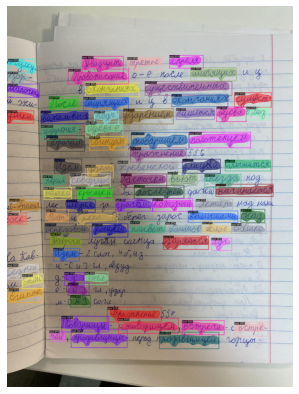

In [22]:
id_image_selected = 3
example = dataset_dicts_val[id_image_selected]
im = cv2.imread(example["file_name"])
outputs = predictor(im)
plt.figure(figsize=(7,7))
v = Visualizer(im[:, :],
              metadata=val_metadata, 
              scale=0.4 )
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
plt.imshow(v.get_image()[:, :, ::-1])
plt.axis('off')
plt.show()

В качестве предсказаний для каждого изображения из тестового набора требуется получить бинарную маску, в которой `1` означает, что данный пиксель относится к классу текста.

Давайте на примере одного изображения переведем формат выхода Detectron2 в требуемый формат для соревнования.

`outputs` - результат предсказания модели на данном изображении из предыдущего блока с кодом

In [23]:
prediction = outputs['instances'].pred_masks.cpu().numpy()

In [24]:
prediction.shape

(77, 4032, 3024)

В `prediction` находится массив бинарных матриц. Каждая матрица отвечает за отдельную задетектированную маску текста. В нашем случае модель задетектировала 80 текстовых масок. Давайте провизуализируем одну из них.

In [25]:
prediction[0]

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

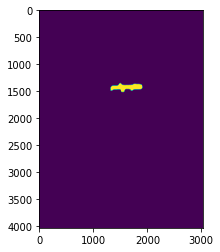

In [26]:
plt.imshow(prediction[0])

Отлично. Теперь, для того, чтобы получить бинарную маску со всем задетектированным текстом для изображения, нам нужно объединить все маски в одну. Для этого мы просто поэелементно сложим все наши матрицы. Там, где после сложения остались нули - модель не задетектировала никакого текста.

In [27]:
mask = np.add.reduce(prediction)

In [28]:
mask = mask > 0

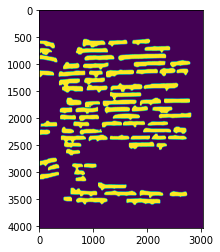

In [29]:
plt.imshow(mask)

Итак, нам нужно полуить такую маску для каждого изображения из валидационной выборки, а затем посчитать метрику F1-score.

In [30]:
#Подгрузим аннотации train
with open('data/val/annotations_new.json') as f:
    annotations_val = json.load(f)

In [31]:
val_images = annotations_val['images']

In [32]:
val_predictions = {}

In [33]:
for val_img in tqdm.tqdm_notebook(val_images):
    file_name = val_img['file_name']
    img_path = os.path.join('data/val/images/',file_name)
    im = cv2.imread(img_path)
    outputs = predictor(im)
    prediction = outputs['instances'].pred_masks.cpu().numpy()
    mask = np.add.reduce(prediction)
    mask = mask > 0
    val_predictions[file_name] = mask

  0%|          | 0/66 [00:00<?, ?it/s]

Для сохрания предсказаний и загрузки бинарных масок бы будет использовать формат `.npz`. Он позволяет хранить большие массивы в компактном виде. Вот [ссылка](https://numpy.org/doc/stable/reference/generated/numpy.savez_compressed.html) на документацию.

In [34]:
np.savez_compressed('val_pred.npz',**val_predictions)

Подгрузим бинарные маски для train и val (только что сохраненную). Так как мы в начале бейзлайна разбивали весь исходный train на новый трейн и валидацию, то информация по всем маскам из исходного train хранится в `binary.npz`. 

Получившийся после подгрузки `np.load()` - что то вроде словаря. Его ключи можно получить с помощью метода files - `loaded_val.files`. В нашем случае ключами являются ключи исходного словаря `val_predictions`, то есть названия изображений.

In [35]:
loaded_train = np.load('data/train/binary.npz')

In [36]:
loaded_val_pred = np.load('val_pred.npz')

Мы используем среднюю метрика F1-score. То есть считаем F1-score для каждого изображения, а затем усредняем результаты. 

Реализация из sklearn работает довольно долго, попэтому мы будем использовать свою.

In [37]:
def f1_loss(y_true, y_pred):
        
    
    tp = np.sum(y_true & y_pred)
    tn = np.sum(~y_true & ~y_pred)
    fp = np.sum(~y_true & y_pred)
    fn = np.sum(y_true & ~y_pred)
    
    epsilon = 1e-7
    
    precision = tp / (tp + fp + epsilon)
    recall = tp / (tp + fn + epsilon)
    
    f1 = 2* precision*recall / ( precision + recall + epsilon)

    return f1 

In [38]:
f1_scores = []
for key in tqdm.tqdm_notebook(loaded_val_pred.files):
    pred = loaded_val_pred[key].reshape(-1)
    true = loaded_train[key].reshape(-1)
    
    f1_img = f1_loss(true,pred)
    f1_scores.append(f1_img)

  0%|          | 0/66 [00:00<?, ?it/s]

Получившаяся метрика на валидации.

In [39]:
np.mean(f1_scores)

0.605444142491414

# Запись submission

Как уже говорилось ранее, правильные и предсказанные маски мы будем хранить в компактном формате `npz`. 

Возьмем нашу обученную модель и запишем предсказания в файл `prediction.npz`

In [40]:
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.structures import Boxes, BoxMode 


In [49]:
def run(test_images_path,predictions_output_path):
    threshold = 0.5
    model_path = "./output/model_0002999.pth"
    
    
    cfg = get_cfg()
    cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")) 
    cfg.MODEL.WEIGHTS = model_path
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = threshold   # set the testing threshold for this model
    cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1
    cfg.INPUT.MIN_SIZE_TEST= 300
    cfg.INPUT.MAX_SIZE_TEST = 300
    cfg.INPUT.FORMAT = 'BGR'
    cfg.TEST.DETECTIONS_PER_IMAGE = 1000
    
    
    
    predictor = DefaultPredictor(cfg)
    results = {}
    
    
    for img in os.listdir(test_images_path):
        img_path = os.path.join(test_images_path,img)
        im = cv2.imread(img_path)
        outputs = predictor(im)
        prediction = outputs['instances'].pred_masks.cpu().numpy()
        mask = np.add.reduce(prediction)
        mask = mask > 0
        
        results[img] = mask  
    np.savez_compressed(predictions_output_path,**results)


В функцию передаем два аргумента:
* путь к папке с изображениями, на которых хотим сделать предсказания. сейчас это путь к валдиационными изображениям. При загрузке вашего образа стоит использовать путь `/home/jovyan/input/images`. Папку test мы положим во время запуска контейнера.
* путь к создаваемому файлу с предсказаниями. по время локального дебага можно использовать любое имя, для сабмита в систему стоит использовать название `prediction.npz`

Этот же код вынесен в отдельные скрипты для удобства, они должны запускаться во время запуска контейнера.

In [50]:
run('data/val/images','prediction.npz')

# Оценка качества.

Оценка качества на нашей стороне просходит по следующему скрипту - `evaluate.py`. Он принимает на вход путь к двум файлам формата `npz`. 
* `ref_path` - путь к файлу с правильными ответами 
* `pred_path` - путь к файлу с предсказаниями

Для начала сгенерируем файл формата `npz` для валидации.

In [51]:
val_true = {}
for i in loaded_train.files:
    if i in val_predictions.keys():
        val_true[i] = loaded_train[i]

In [52]:
np.savez_compressed('val_true.npz',**val_true)

In [53]:
!python evaluate.py --ref_path val_true.npz --pred_path val_pred.npz

0.60544
